In [21]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import libs.ngl as ngl
import datetime
from numba import njit
from numba.typed import Dict
from sklearn.metrics.pairwise import haversine_distances
import numpy.fft as fft
import scipy.stats as stats
from scipy.special import kn
import matplotlib

In [2]:
def load_hauksson():
    column_names = ["year","month","day", "hour", "minut", 'sec', "id",
                    "lat","lon", "depth", "mag", "nPhases", "azGap", "nearDist", "hErr", "vErr", "residual", "flag1", "flag2"]
    df = pd.read_csv("catalogs/sc_1981_2022q1_1d_3d_gc_soda.gc", sep="\s+", usecols=range(0,11), header=None,names=column_names[:11])
    df['time'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day, hours=df.hour, minutes=df.minut, seconds=df.sec))
    return df

In [3]:
# grab GPS stations list
station_list = ngl.ngl_process_list(ngl.ngl_24h_2w) # daily measurements, with 2 weeks delay

In [4]:
# fill a dictionary with all the stations coordinates inside the region box
region_limits = [29.0, 37.0, -123.0, -112.0 ]
station_names, station_lats, station_lons  = ngl.get_all_stations_box(station_list, *region_limits)

In [5]:
catalog = load_hauksson()
catalog.head(5)

,year,month,day,hour,minut,sec,id,lat,lon,depth,mag,time
0,1981,1,1,1,49,29.357,3301561,33.73166,-118.81097,6.399,2.27,1981-01-01 01:49:29.357
1,1981,1,1,4,13,55.936,3301565,33.25355,-115.96716,6.347,2.26,1981-01-01 04:13:55.936
2,1981,1,1,5,20,14.634,3301566,34.18175,-117.30450,5.864,2.37,1981-01-01 05:20:14.634
3,1981,1,1,5,39,56.616,3301567,34.18031,-117.30303,5.991,1.60,1981-01-01 05:39:56.616
4,1981,1,1,8,23,18.236,3301570,34.00782,-117.16284,15.468,1.88,1981-01-01 08:23:18.236


In [6]:
# either download or load, depending whether they are on disk or not
rootpath = "csv_24/"
station_data = {}
for s_cnt, s_name in enumerate(station_names):
    df, status = ngl.ngl_retrieve_24h(rootpath, s_name)
    print(s_name, status)
    station_data[s_name] = df

59WE loaded
5PTS loaded
7ODM loaded
ACES loaded
ACSB loaded
ACSX loaded
AERO loaded
AGMT loaded
AGUA loaded
AIAH loaded
AISD loaded
ALPP loaded
ALTH loaded
ANA1 loaded
AOA1 loaded
APEX loaded
AQUA loaded
AR27 loaded
AR53 loaded
ARGU loaded
ARM1 loaded
ARM2 loaded
ASHM loaded
AUBR loaded
AVON loaded
AVRY loaded
AZAO loaded
AZBC loaded
AZBH loaded
AZBK loaded
AZDS loaded
AZFM loaded
AZGA loaded
AZGE loaded
AZGV loaded
AZKG loaded
AZLH loaded
AZLQ loaded
AZM1 loaded
AZMO loaded
AZMP loaded
AZNE loaded
AZPA loaded
AZPE loaded
AZPK loaded
AZPR loaded
AZPS loaded
AZPV loaded
AZPX loaded
AZQZ loaded
AZRY loaded
AZS1 loaded
AZSG loaded
AZTH loaded
AZU1 loaded
AZWA loaded
AZWB loaded
AZWE loaded
AZWK loaded
AZYC loaded
AZYU loaded
AZYW loaded
BADL loaded
BAK1 loaded
BAKR loaded
BAR1 loaded
BATM loaded
BBDM loaded
BBRY loaded
BCWR loaded
BEER loaded
BEMT loaded
BEPK loaded
BFLD loaded
BFSH loaded
BGIS loaded
BILL loaded
BIRD loaded
BKAP loaded
BKMS loaded
BKR1 loaded
BKR2 loaded
BLSA loaded
BLYT

In [35]:
from sklearn import linear_model
from scipy.spatial import ConvexHull
import scipy.spatial     

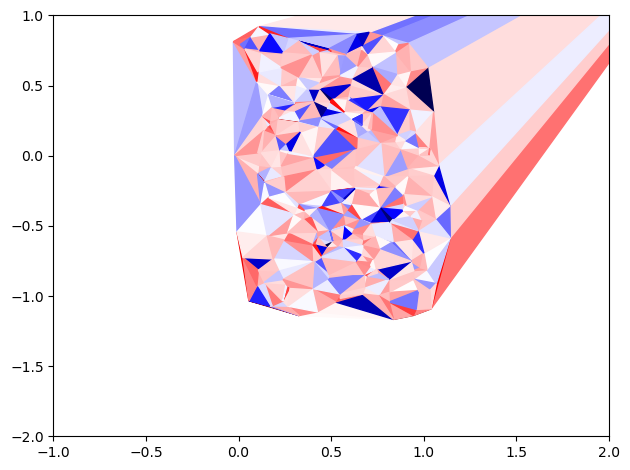

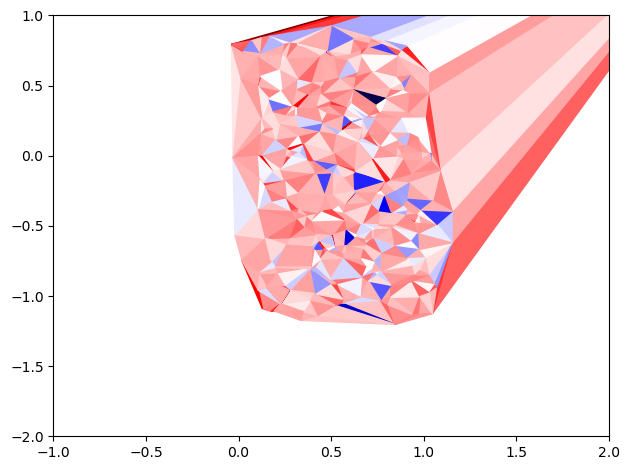

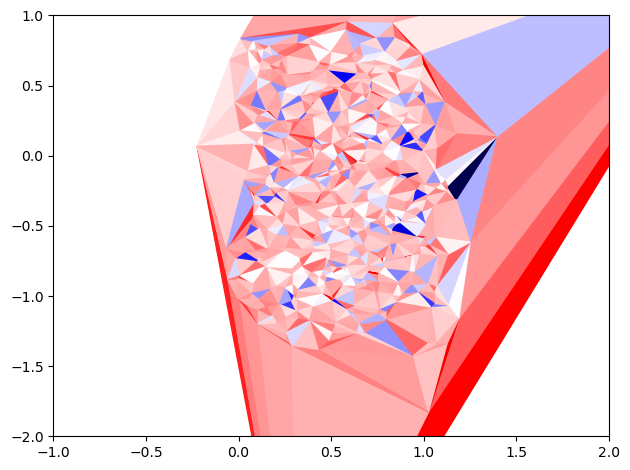

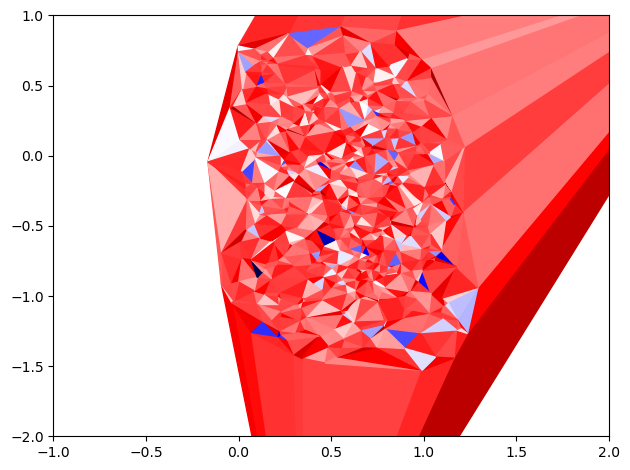

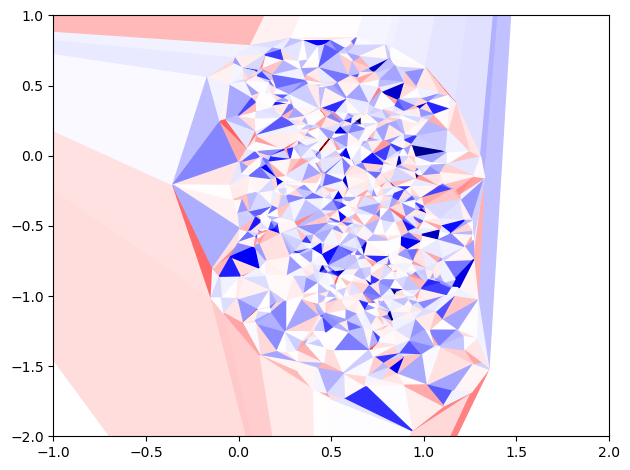

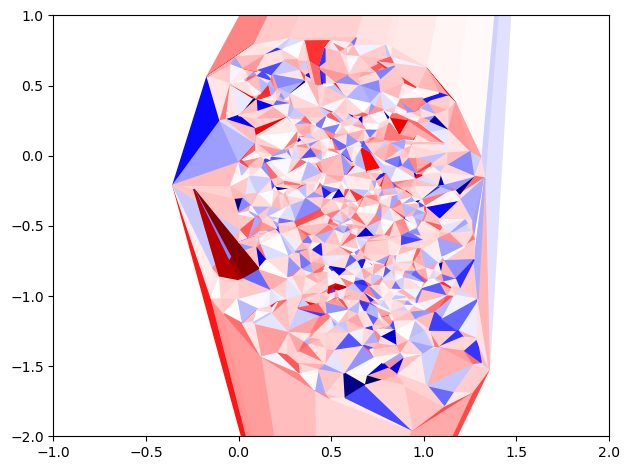

In [81]:
reference_mag = 6
reference_quakes = catalog[catalog.mag >= reference_mag]
maximal_radius = 50/6371
stacked_latslons = np.vstack([station_lats, station_lons]).T
n_days_backward = 10
for _,quake in reference_quakes.iterrows():
    day_end = datetime.datetime(quake.time.year, quake.time.month, quake.time.day)
    day_start = day_end - datetime.timedelta(n_days_backward)
    u_stat = []
    pos_stat = []
    for name, s_lat, s_lon in zip(station_names, station_lats, station_lons):
        data = station_data[name]
        daily_coords = data[ (data.date >= day_start)*(data.date <= day_end)][['north','east']].values
        if(len(daily_coords) == n_days_backward+1):
            u_stat.append(daily_coords[None,:,:])
            pos_stat.append(np.array([s_lat, s_lon])[None,:])
    if(len(u_stat) == 0):
        continue
    u_stat = np.concatenate(u_stat, axis=0)
    pos_stat = np.concatenate(pos_stat, axis=0)
    
    
    tri = scipy.spatial.Delaunay(u_stat[:,0,:]) 
    n_simplices = len(tri.simplices)
    simplices = tri.simplices
    centers = np.array([ u_stat[s,0,:].mean(axis=0)   for s in simplices ])
    R_ab_ref =np.array([ u_stat[s,None,0, :]-u_stat[None,s, 0, :]    for s in simplices  ])
    R_matr_ref = np.zeros((R_ab_ref.shape[0], 2, 2))
    R_matr_ref[:, :, 0] = R_ab_ref[:, 1, 0, :]
    R_matr_ref[:, :, 1] = R_ab_ref[:, 2, 1, :]
    for t_i in range(1, u_stat.shape[1]):
        if(t_i < n_days_backward):
            continue
        R_ab =np.array([ u_stat[s,None,t_i, :]-u_stat[None,s, t_i, :]    for s in simplices  ])

        R_matr = np.zeros((R_ab.shape[0], 2, 2))
        R_matr[:, :, 0] = R_ab[:, 1, 0, :]
        R_matr[:, :, 1] = R_ab[:, 2, 1, :]


        M = R_matr*np.linalg.inv(R_matr_ref)
        dN = np.array([  scipy.linalg.logm(m @ m.T)*0.5  for m in M])
        expansion = np.einsum("sii", dN)
        rot = np.array([ np.linalg.inv(scipy.linalg.expm(dn)) @ m  for (m,dn) in zip(M,dN)])
        v = np.swapaxes(M, axis1=1,axis2=2) - np.repeat(np.eye(2, 2)[None,:,:], M.shape[0], axis=0)
        vT = np.swapaxes(v, axis1=1, axis2=2)
        trV = np.trace(v, axis1=1, axis2=2)[:,None,None]*np.repeat(np.eye(2, 2)[None,:,:], M.shape[0], axis=0)/2
        tlsV = (v+vT)/2 - trV
        nematicNorm = np.sqrt(tlsV[:, 0, 0]**2 + tlsV[:, 0, 1]**2)
        nematicCos2Angle = tlsV[:, 0, 0]/nematicNorm
        omegaV = v - trV - tlsV
        cmap = matplotlib.colormaps['seismic']
        max_norm, min_norm = np.log(nematicNorm).max(), np.log(nematicNorm).min()
        #colors = cmap((np.log(nematicNorm)-min_norm)/(max_norm-min_norm))
        #colors = cmap((1+nematicCos2Angle)/2)
        colors = cmap((expansion-expansion.min())/(expansion.max()-expansion.min()))
        fig, ax = plt.subplots()
        ax.set_xlim(-1,2)
        ax.set_ylim(-2,1)
        #ax.scatter(centers[:, 0], centers[:,1])
        for color, s in zip(colors, simplices):

            ax.add_patch(plt.Polygon(u_stat[s, t_i, :], color=color))
        plt.tight_layout()
        plt.show()

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


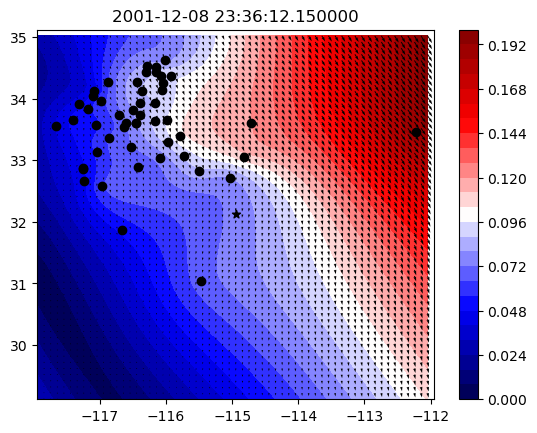

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


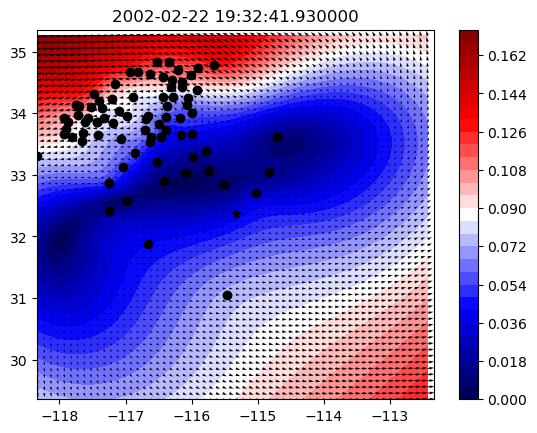

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


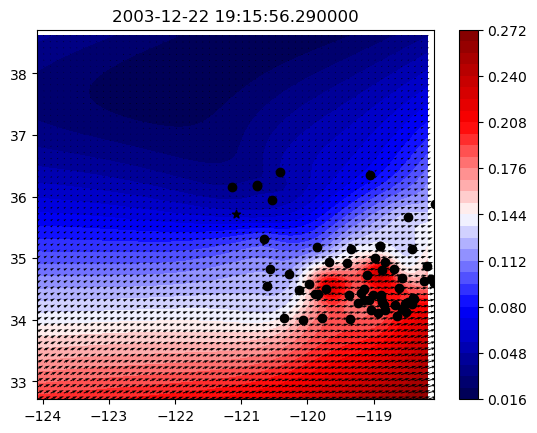

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


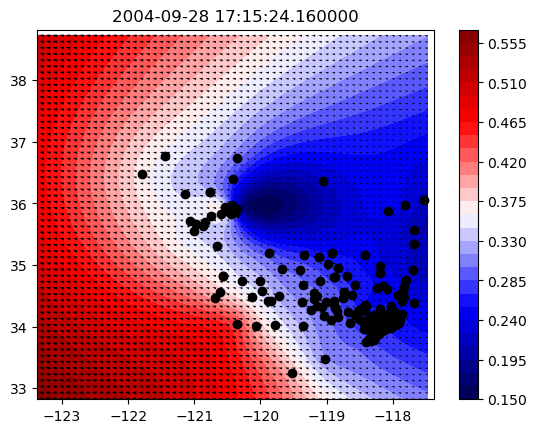

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


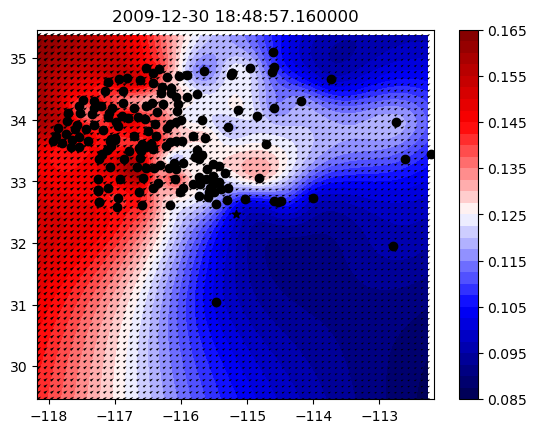

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


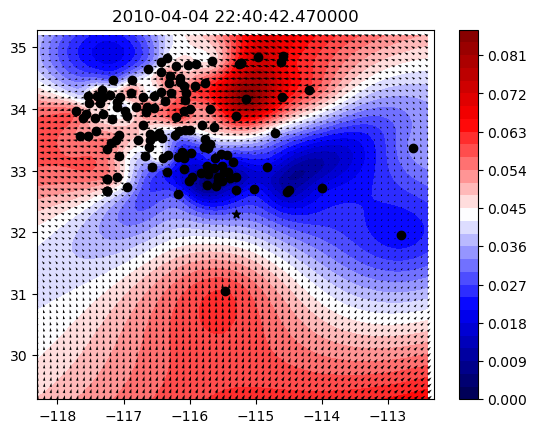

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


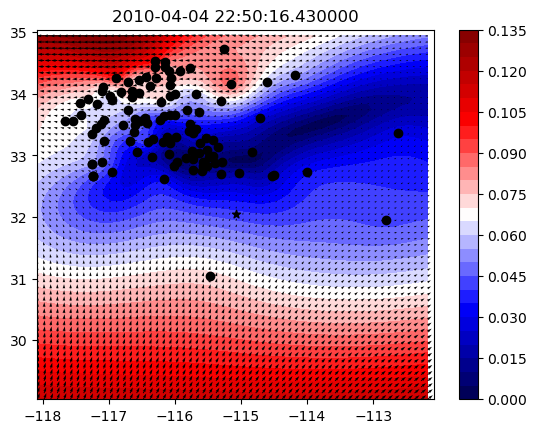

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


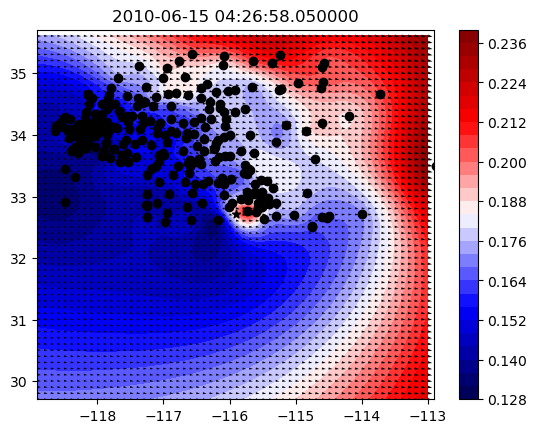

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


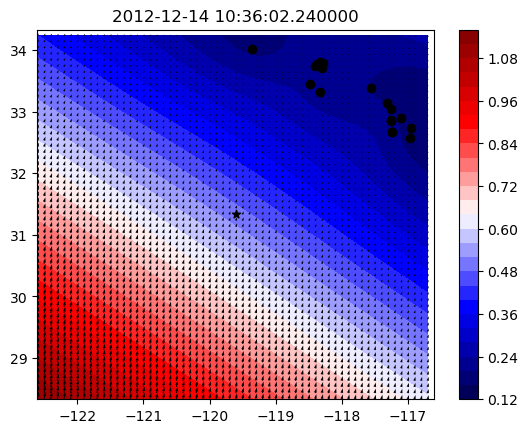

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


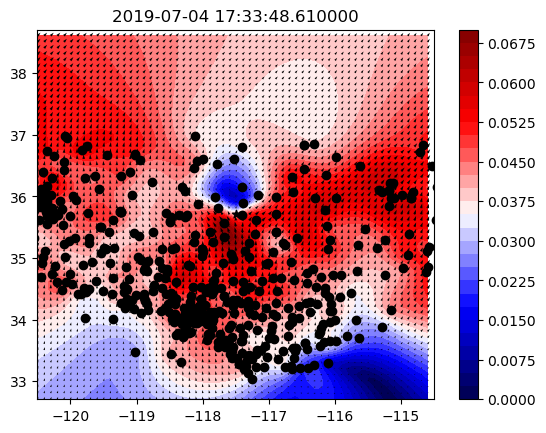

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


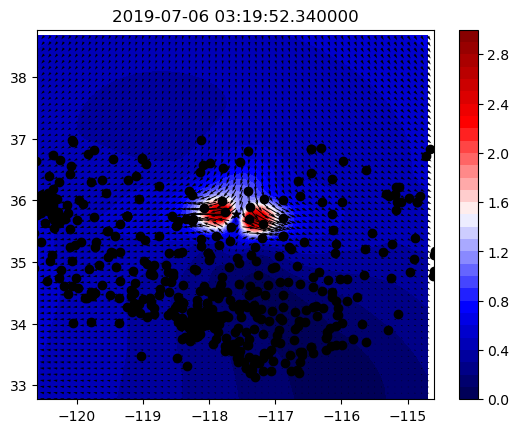

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


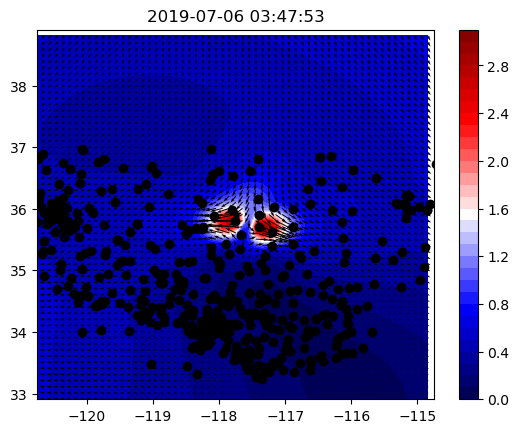

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


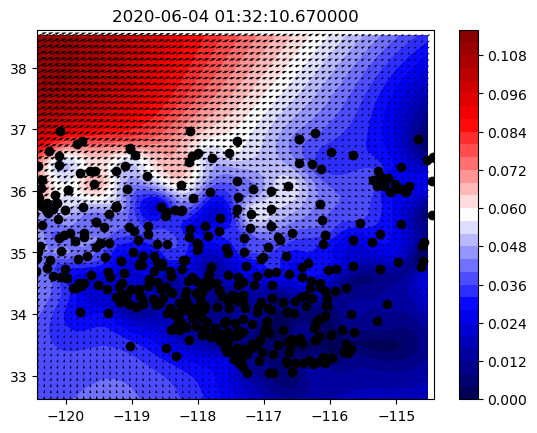

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: divide by zero encountered in log
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_82154/4154741124.py:34: RuntimeWarning: invalid value encountered in add
  gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)


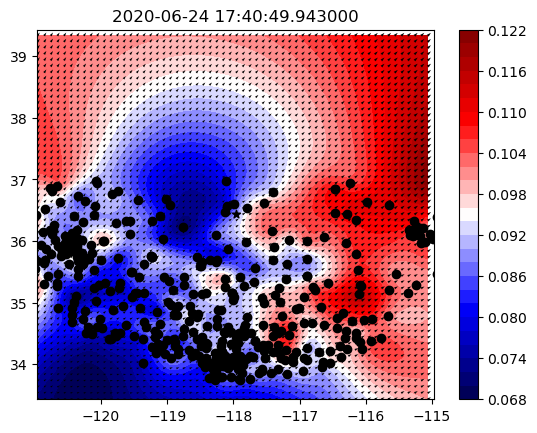

In [436]:
reference_mag = 5.5
reference_quakes = catalog[catalog.mag >= reference_mag]
maximal_radius = 300/6371
stacked_latslons = np.vstack([station_lats, station_lons]).T
n_days_backward = 10
cell_degs = 0.1
half_size = 30
for _,quake in reference_quakes.iterrows():
    day = datetime.datetime(quake.time.year, quake.time.month, quake.time.day)
    day_start = day - datetime.timedelta(n_days_backward)
    center = quake[['lat','lon']].values.astype('float')
    stations_to_center_dists = haversine_distances(np.radians(stacked_latslons), np.radians(center)[None,:2])[:,0]
    stations_to_pick = stations_to_center_dists <= maximal_radius
    velocity_data_list = []
    for name, s_lat, s_lon in zip(station_names[stations_to_pick], station_lats[stations_to_pick], station_lons[stations_to_pick]):
        data = station_data[name]
        daily_coords = data[ (data.date >= day_start)*(data.date <= day)][['lat','lon']].values
        if(len(daily_coords) == n_days_backward+1):
            daily_coords_diff = np.diff(daily_coords,axis=0)
            velocity_data_list.append(np.concatenate([daily_coords[-2,:], daily_coords_diff[-1,:]]) )
    if(len(velocity_data_list)>0):
        velocity_data = np.array(velocity_data_list)
        lat_min, lat_max = quake.lat - cell_degs*half_size, quake.lat +  cell_degs*half_size
        lon_min, lon_max = quake.lon - cell_degs*half_size, quake.lon +  cell_degs*half_size
        clf_north = linear_model.LinearRegression().fit(velocity_data[:,:2], velocity_data[:,2])
        clf_east = linear_model.LinearRegression().fit(velocity_data[:,:2], velocity_data[:,3])
        interp_north = np.dot(velocity_data[:,:2], clf_north.coef_) + clf_north.intercept_
        interp_east = np.dot(velocity_data[:,:2], clf_north.coef_) + clf_north.intercept_
        residuals = np.concatenate([(velocity_data[:, 2] - interp_north).reshape(-1, 1), (velocity_data[:, 3] - interp_east).reshape(-1,1)], axis=1)
        points_distances = haversine_distances(np.radians(velocity_data[:, :2]))
        alpha = 50/points_distances.max()
        tension = 0.1
        p_sq = tension/(1-tension)
        gf_data = kn(0,np.sqrt(p_sq)*alpha*points_distances)+np.log(np.sqrt(p_sq)*alpha*points_distances)
        gf_data[np.isnan(gf_data)] = 0
        forces = np.matmul(np.linalg.inv(gf_data), residuals)

        yy, xx = np.meshgrid(np.arange(0, 2*half_size)*cell_degs + lat_min, np.arange(0, 2*half_size)*cell_degs + lon_min, indexing='ij')
        yyxx = np.concatenate([yy.reshape(-1,1), xx.reshape(-1,1)], axis=1)
        distances = haversine_distances(np.radians(yyxx), np.radians(velocity_data[:, :2]))
        gf_eval = kn(0,p_sq*alpha*distances )+np.log(p_sq*alpha*distances)
        gf_eval[np.isnan(gf_eval)] = 0
        field =  np.matmul(gf_eval, forces)
        field[:,0] += np.dot(yyxx, clf_north.coef_) + clf_north.intercept_
        field[:,1] += np.dot(yyxx, clf_east.coef_) + clf_east.intercept_
        field = field.reshape((2*half_size,2*half_size,2))
        plt.contourf( xx,yy, 6371*1e3*np.linalg.norm(field, axis=-1), cmap='seismic', levels=30)
        plt.colorbar()
        plt.quiver(xx, yy, field[:,:, 1], field[:,:, 0])
        future_quakes = catalog[(catalog.time > day)*(catalog.time <= day + datetime.timedelta(3))]
        #plt.scatter(future_quakes.lon, future_quakes.lat, color='yellow', marker='*')
        plt.scatter(velocity_data[:,1], velocity_data[:,0], color='black')
        plt.scatter(quake.lon, quake.lat, color='black', marker="*")
        plt.xlim(lon_min, lon_max)
        plt.ylim(lat_min, lat_max)
        plt.title(quake.time)
        plt.show()
